In [1]:
import ml as ml_root
print(ml_root.__version__)

ModuleNotFoundError: No module named 'ml'

In [2]:
import os

# These environment variables control where training and eval logs are written.
# You can set these in your shell profile as well.
os.environ["RUN_DIR"] = "runs"
os.environ["EVAL_RUN_DIR"] = "eval_runs"
os.environ["MODEL_DIR"] = "models"
os.environ["DATA_DIR"] = "data"

# This is used to set a constant Tensorboard port.
os.environ["TENSORBOARD_PORT"] = str(8989)

# Useful for debugging.
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import ml.api as ml  # Source: https://github.com/codekansas/ml-starter

ml.configure_logging()

# Imports these files to add them to the model and task registry.
from usa.models.point2emb import Point2EmbModel, Point2EmbModelConfig
from usa.tasks.clip_sdf import ClipSdfTask

ModuleNotFoundError: No module named 'ml'

In [4]:
import math
import pickle as pkl
import zipfile
from pathlib import Path
from typing import Iterator

import cv2
import imageio
import matplotlib.pyplot as plt
import ml.api as ml
import numpy as np
#import pybullet as pb
import requests
import torch
from IPython.display import Image
from omegaconf import OmegaConf
from pyquaternion import Quaternion
from scipy.spatial.transform import Rotation
from torch import Tensor

The code below downloads the environment data and adds it to PyBullet.

Next, let's collect some samples from the environment. The `PosedRGBDItem` used for training the model has the following description:

```python
class PosedRGBDItem(NamedTuple):
    image: Tensor       # RGB image, with shape (C, H, W)
    depth: Tensor       # Depth image, with shape (1, H, W)
    mask: Tensor        # Valid depth points, with shape (1, H, W), where True means valid
    intrinsics: Tensor  # Camera intrinsics matrix, with shape (3, 3)
    pose: Tensor        # Camera pose matrix, with shape (4, 4)

    def check(self) -> None:
        # Image should have shape (C, H, W)
        assert self.image.dim() == 3
        assert self.image.dtype == torch.float32
        # Depth should have shape (1, H, W)
        assert self.depth.dim() == 3
        assert self.depth.shape[0] == 1
        assert self.depth.dtype == torch.float32
        # Depth shape should match image shape.
        assert self.depth.shape[1:] == self.image.shape[1:]
        assert self.mask.shape[1:] == self.image.shape[1:]
        # Intrinsics should have shape (3, 3)
        assert self.intrinsics.shape == (3, 3)
        assert self.intrinsics.dtype == torch.float64
        # Pose should have shape (4, 4)
        assert self.pose.shape == (4, 4)
        assert self.pose.dtype == torch.float64
```

In the example below, we move the camera around the center point to collect a few frames.

In [ ]:
import wandb
wandb.init(project="usa-net", name = "nyukitchen", entity="peiqiliu")

Next, we train a model on the recorded clip.

In [5]:
# Using the default config, but overriding the dataset.
config = OmegaConf.load("config.yaml")
#config.task.dataset = "r3d"
config.task.dataset = "/data/peiqi/home_engine/usa/Kitchen.r3d"

# We still need to explicitly set these variables.
config.trainer.exp_name = "4_256_no"
config.trainer.base_run_dir = "nyu_kitchen"
config.trainer.run_id = 0

# Only use stdout logger.
config.logger = [{"name": "stdout"}]
config.task.dataloader.train.batch_size = 16

# You can change this number to change the number of training steps.
config.task.finished.max_steps = 8000
#config.task.finished.max_epochs = 1000

# Loads the config objects.
objs = ml.instantiate_config(config)

# Unpacking the different components.
model = objs.model
#model_conf = Point2EmbModelConfig()
#model_conf.num_layers = 6
#model_conf.hidden_dims = 256 
#model_conf.norm = "layer"
#model_conf.num_pos_embs = 6 
#model_conf.output_dims = 513
#model = Point2EmbModel(model_conf)
task = objs.task
optimizer = objs.optimizer
lr_scheduler = objs.lr_scheduler
trainer = objs.trainer

# Runs the training loop.
trainer.train(model, task, optimizer, lr_scheduler)

  INFO   2023-08-28 10:02:22 [ml.trainers.base] Experiment directory: /data/peiqi/home_engine/usa/notebooks/nyu_kitchen/4_256_no/run_0
  INFO   2023-08-28 10:02:22 [ml.core.registry] Components:
 ↪ Model: usa.models.point2emb.Point2EmbModel (/data/peiqi/home_engine/usa/usa/models/point2emb.py)
 ↪ Task: usa.tasks.clip_sdf.ClipSdfTask (/data/peiqi/home_engine/usa/usa/tasks/clip_sdf.py)
 ↪ Trainer: ml.trainers.sl.SupervisedLearningTrainer (/home/robot-lab/anaconda3/envs/usa/lib/python3.10/site-packages/ml/trainers/sl.py)
 ↪ Optimizer: ml.optimizers.adam.AdamOptimizer (/home/robot-lab/anaconda3/envs/usa/lib/python3.10/site-packages/ml/optimizers/adam.py)
 ↪ LR Scheduler: ml.lr_schedulers.linear.LinearLRScheduler (/home/robot-lab/anaconda3/envs/usa/lib/python3.10/site-packages/ml/lr_schedulers/linear.py)
 ↪ Launcher: ml.launchers.slurm.SlurmLauncher (/home/robot-lab/anaconda3/envs/usa/lib/python3.10/site-packages/ml/launchers/slurm.py)
WARNING  2023-08-28 10:02:22 [ml.trainers.base] Overwri

/home/robot-lab/anaconda3/envs/usa/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading R3D file: 100%|██████████████████████████████████████████████████████████████| 880/880 [00:05<00:00, 156.09it/s]


WARNING  2023-08-28 10:02:30 [ml.utils.timer] Finished getting datasets in 5.7 seconds


/home/robot-lab/anaconda3/envs/usa/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|███████████████████████████████████████████████████████████████████████████████| 392/392 [00:00<00:00, 2016.33it/s]

  INFO   2023-08-28 10:02:32 [stdout] valid [10 seconds] {"loss": {"clip": 5.873, "sdf": 0.2033}, "task": {"pmax": 0.7759, "pmin": -0.8452}, "timers": {"epoch": 145, "dt": {"forward": 2.321, "get_single_loss": 0.0002317, "iter": 12.76, "log_losses": 0.0002325}, "hours": {"epoch": -9.226e-11}, "samples": {"hour": 0, "second": 0, "total": 128000}, "steps": {"hour": 0, "second": 0, "total": 8000}}}
  INFO   2023-08-28 10:02:32 [ml.trainers.base] Saving checkpoint to /data/peiqi/home_engine/usa/notebooks/nyu_kitchen/4_256_no/run_0/checkpoints/ckpt.8000.pt


  INFO   2023-08-28 10:02:32 [ml.trainers.sl] Finished training after 145 epochs, 8000 steps, 128000 samples
  INFO   2023-08-28 10:02:32 [ml.trainers.base] Exiting training job for /data/peiqi/home_engine/usa/notebooks/nyu_kitchen/4_256_no/run_0/config.yaml


In [6]:
import sys
sys.path.append('../usa')
from planners.clip_sdf import AStarPlanner, GradientPlanner

dataset = task._dataset
grid_planner = AStarPlanner(
    dataset=dataset,
    model=model.double(),
    task=task.double(),
    device=task._device,
    # The heuristic to use for AStar
    heuristic="euclidean",
    # The grid resolution
    resolution=0.1,
    # Where to store cache artifacts
    cache_dir=None,
    # Height of the floor
    floor_height=-1,
    # Height of the ceiling
    ceil_height=0,
    occ_avoid_radius = 0.2
).double()

# Builds the planner from the model and task.
gradient_planner = GradientPlanner(
    dataset=dataset,
    model=model.double(),
    task=task.double(),
    device=task._device,

    # The learning rate for the optimizer for the waypoints
    lr=1e-3,
    # The weight for the total path distance loss term
    dist_loss_weight=1.0,
    # The weight for the inter-point distance loss term
    spacing_loss_weight=1.0,
    # The weight for the "no-crashing-into-a-wall" loss term
    occ_loss_weight=25.0,
    # The weight for the loss term of the final semantic location
    sim_loss_weight=15.0,
    # Maximum number of optimization steps
    num_optimization_steps=100,
    # The grid resolution
    # If points move less than this distance, stop optimizing
    min_distance=1e-5,
    # Where to store cache artifacts
    # cache_dir=Path("cache"),
    cache_dir=None,
    # Height of the floor
    floor_height=-1,
    # Height of the ceiling
    ceil_height=0,
    occ_avoid_radius = 0.2
).double()

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:01<00:00, 290.63it/s]


After the model has been trained, we can load it and visualize some of the planned trajectories.

<Axes: >

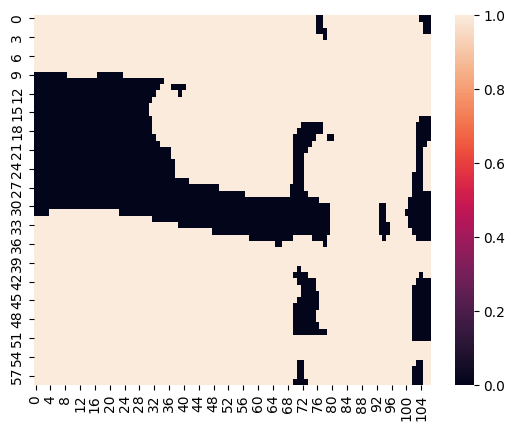

In [7]:
import seaborn
seaborn.heatmap(gradient_planner.base_planner.a_star_planner.is_occ[:, :, 0][::-1])

We plot the occupancy grid with the camera trajectories below.

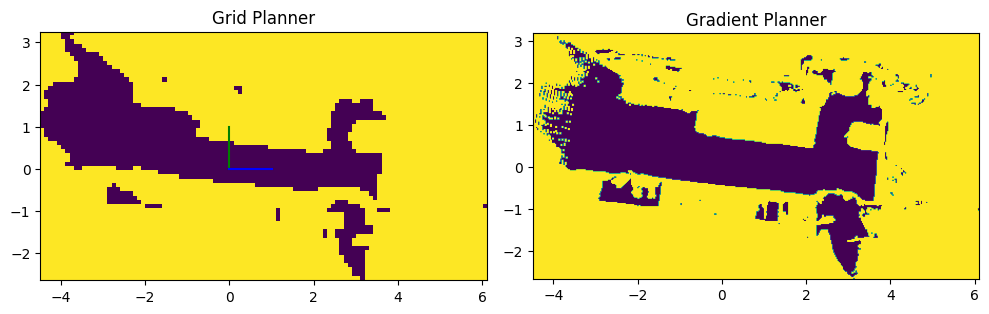

In [8]:
dataset = task._dataset
poses = torch.stack([dataset[i].pose for i in range(len(dataset))])
xs, ys = poses[..., 0, 3].numpy(), poses[..., 1, 3].numpy()

plt.figure(figsize=(10, 20))

plt.subplot(1, 2, 1)
minx, miny = grid_planner.occ_map.origin
(ycells, xcells), resolution = grid_planner.occ_map.grid.shape, grid_planner.occ_map.resolution
maxx, maxy = minx + xcells * resolution, miny + ycells * resolution
plt.imshow(grid_planner.occ_map.grid[::-1], extent=(minx, maxx, miny, maxy))
#plt.scatter(x=xs, y=ys, c='r', s=1.0)
plt.plot((0, 0), (0, 1), c= 'g')
plt.plot((0, 1), (0, 0), c = 'b')
plt.title("Grid Planner")

plt.subplot(1, 2, 2)
minx, miny = gradient_planner.occ_map.origin
(ycells, xcells), resolution = gradient_planner.occ_map.grid.shape, gradient_planner.occ_map.resolution
maxx, maxy = minx + xcells * resolution, miny + ycells * resolution
plt.imshow(gradient_planner.occ_map.grid[::-1], extent=(minx, maxx, miny, maxy))
#plt.scatter(x=xs, y=ys, c='r', s=1.0)
plt.title("Gradient Planner")

plt.tight_layout()
plt.show();

In [15]:
# waypoints = [(-5.0 + i * 0.1, 0.0) for i in range(20)]
gradient_waypoints = gradient_planner.plan(start_xy=(0.0, 0.0), end_xy=(3.5078125, 1.1515625))
#gradient_waypoints = gradient_planner.plan(start_xy=(-2.0, 1.0), end_goal="Chair")
grid_waypoints = grid_planner.plan(start_xy=(0.0, 0.0), end_xy=(3.5078125, 1.1515625))
#grid_waypoints = grid_planner.plan(start_xy=(-2.0, 1.0), end_goal="Chair")
#waypoints = planner.plan(start_xy=(0.0, -3.0), end_xy=(1.0, -3.0))
grid_waypoints, gradient_waypoints

ValueError: No path found

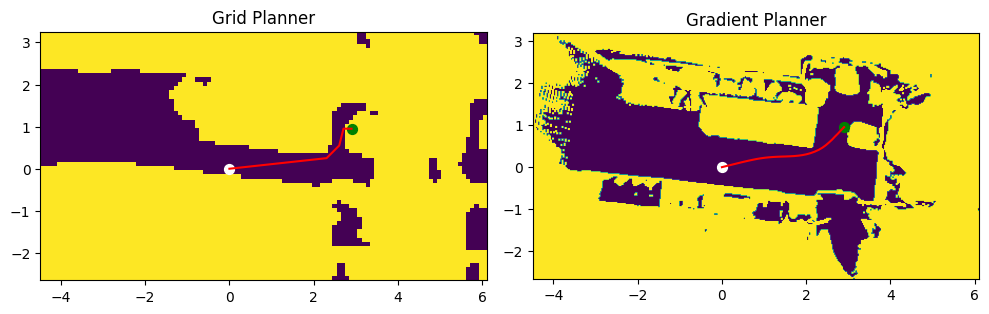

In [25]:
xs, ys = zip(*grid_waypoints)

plt.figure(figsize=(10, 20))

plt.subplot(1, 2, 1)
minx, miny = grid_planner.occ_map.origin
(ycells, xcells), resolution = grid_planner.occ_map.grid.shape, grid_planner.occ_map.resolution
maxx, maxy = minx + xcells * resolution, miny + ycells * resolution
plt.imshow(grid_planner.a_star_planner.is_occ[:, :, 0][::-1], extent=(minx, maxx, miny, maxy))
#plt.imshow(grid_planner.occ_map.grid[::-1], extent=(minx, maxx, miny, maxy))
#plt.imshow(sim.detach().cpu(), extent=(minx, maxx, miny, maxy))
plt.plot(xs, ys, c='r')
plt.scatter(xs[0], ys[0], s = 50, c = 'white')
plt.scatter(xs[-1], ys[-1], s = 50, c = 'g')
plt.title("Grid Planner")

xs, ys = zip(*gradient_waypoints)
plt.subplot(1, 2, 2)
minx, miny = gradient_planner.occ_map.origin
(ycells, xcells), resolution = gradient_planner.occ_map.grid.shape, gradient_planner.occ_map.resolution
maxx, maxy = minx + xcells * resolution, miny + ycells * resolution
plt.imshow(gradient_planner.occ_map.grid[::-1], extent=(minx, maxx, miny, maxy))
plt.plot(xs, ys, c='r')
plt.scatter(xs[0], ys[0], s = 30)
plt.scatter(xs[0], ys[0], s = 50, c = 'white')
plt.scatter(xs[-1], ys[-1], s = 50, c = 'g')
#plt.plot((0, 0), (0, 1), c= 'g')
#plt.plot((0, 1), (0, 0), c = 'b')
plt.title("Gradient Planner")

plt.tight_layout()
plt.show();

Now that we've got our trajectory, we can run it in simulation.

(<Figure size 5000x7000 with 9 Axes>, <Figure size 5000x7000 with 9 Axes>)

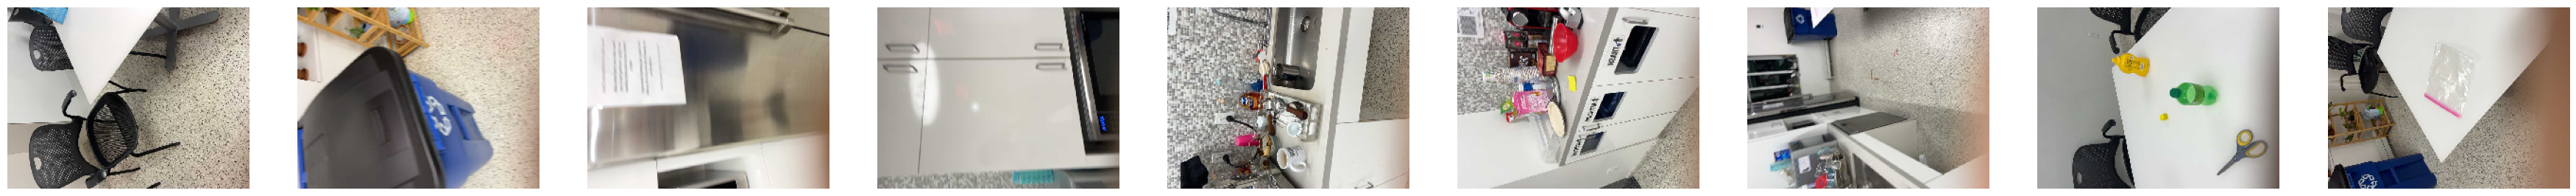

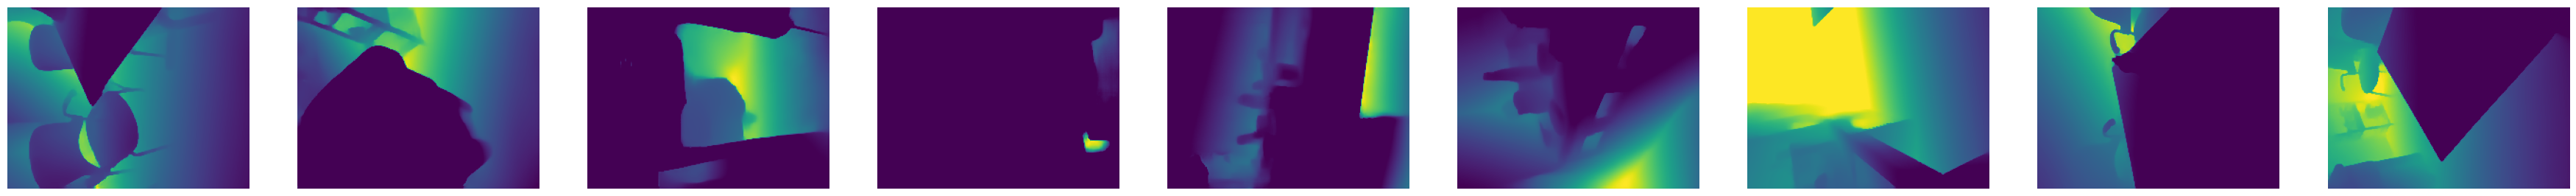

In [10]:
from matplotlib import pyplot as plt
import torch
images = plt.figure(figsize = (50, 70))
depths = plt.figure(figsize = (50, 70))
for i, items in enumerate(dataset):
    if i % 100 != 0:
        continue
    ax1 = images.add_subplot(16, 10, i // 100 + 1)
    ax1.imshow(items[0].permute(2, 1, 0))
    ax1.axis('off')
    ax2 = depths.add_subplot(16, 10, i // 100 + 1)
    #print(items[4])
    depth = items[1].clamp(1, 3)
    #ax2.imshow(items[1].permute(1, 2, 0), vmax = items[1].max(), vmin = items[1].min())
    #xi, yi = torch.meshgrid(torch.linspace(0, 1, depth.shape[1]), torch.linspace(0, 1, depth.shape[2]) )
    #ax2.contourf(xi, yi, depth[0], levels = 10000)
    ax2.imshow(depth[0].permute(1, 0))
    ax2.axis('off')
images, depths

In [ ]:
from usa.tasks.datasets.posed_rgbd import get_bounds, get_poses, iter_xyz

def get_occupancy_map_from_dataset(ds, cell_size, occ_height_range, occ_threshold = 1):
    bounds = get_bounds(ds)
    origin = (bounds.xmin, bounds.ymin)
    resolution = cell_size

    min_height, max_height = occ_height_range

    if True:
        xbins, ybins = int(bounds.xdiff / resolution) + 1, int(bounds.ydiff / resolution) + 1
        counts: Tensor | None = None
        any_counts: Tensor | None = None

        # Counts the number of points in each cell.
        with torch.no_grad():
            for xyz, mask_tensor in iter_xyz(ds, "Occupancy Map"):
                xyz = xyz[~mask_tensor]
                xy = xyz[:, :2]

                xs = ((xy[:, 0] - origin[0] + resolution / 2) / resolution).floor().long()
                ys = ((xy[:, 1] - origin[1] + resolution / 2) / resolution).floor().long()

                if counts is None:
                    counts = xy.new_zeros((ybins, xbins), dtype=torch.int32)
                if any_counts is None:
                    any_counts = xy.new_zeros((ybins, xbins), dtype=torch.int32).flatten()

                # Counts the number of occupying points in each cell.
                occ_xys = (xyz[:, 2] >= min_height) & (xyz[:, 2] <= max_height)
                selected = torch.randperm(xs[occ_xys].shape[0])[:xs[occ_xys].shape[0] // 10]
                for (xind, yind) in zip(xs[occ_xys][selected], ys[occ_xys][selected]):
                    if xind < xbins and yind < ybins:
                        counts[yind, xind] += 1

                inds = ys * xbins + xs
                if any_counts.device.type == "mps":
                    any_counts.copy_(any_counts.cpu().index_fill_(0, inds.cpu(), True).to(any_counts))
                else:
                    inds.clamp_(min=0, max=any_counts.numel() - 1)
                    any_counts.index_fill_(0, inds, True)
                

            assert counts is not None and any_counts is not None, "No points in the dataset"
            any_counts = any_counts.reshape((ybins, xbins))

            occ_map = ((counts >= occ_threshold) | ~any_counts).cpu().numpy()
            occ_map_copy = occ_map.copy()

            for i in range(occ_map.shape[0]):
                for j in range(occ_map.shape[1]):
                    if occ_map_copy[i, j] == -1:
                        occ_map[max(0, i - 1): min(occ_map.shape[0] - 1, i + 1), max(0, j - 1): min(occ_map.shape[1] - 1, j + 1)] = -1

    return occ_map

In [22]:
import yaml
metadata = {"xmin": grid_planner.a_star_planner.origin[0], 
            "ymin": grid_planner.a_star_planner.origin[1], 
            "resolution": grid_planner.a_star_planner.resolution}
file=open("map_data.yaml","w")
yaml.dump(metadata,file)
file.close()

import yaml
from pathlib import Path
conf = yaml.safe_load(Path('map_data.yaml').read_text())
conf

{'resolution': 0.1, 'xmin': -4.4921875, 'ymin': -2.6484375}

In [23]:
map_data = yaml.safe_load(Path("map_data.yaml").read_text())
xmin, ymin, resolution = map_data['xmin'], map_data['ymin'], map_data['resolution']


def to_pt(xy):
        return (
            int((xy[0] - xmin) / resolution + 0.5),
            int((xy[1] - ymin) / resolution + 0.5),
        )

def to_xy(pt):
    return (
        pt[0] * resolution + xmin,
        pt[1] * resolution + ymin,
    )

In [24]:
ydiff, xdiff = gradient_planner.occ_map.grid.shape
valid_points = []
for xg in range(grid_planner.occ_map.grid.shape[1]):
    for yg in range(grid_planner.occ_map.grid.shape[0]):
        if grid_planner.occ_map.grid[yg, xg] != -1:
            valid_points.append(to_xy([xg, yg]))
        #x, y = to_xy([xg, yg])
        #if (xg, yg) != to_pt([x, y]):
        #    print((xg, yg), to_pt([x, y]))
        #    print(x - xmin, y - ymin)
        #if not grid_planner.a_star_planner.xy_is_occupied(x, y):
            #print(x, y)
        #    valid_points.append(np.array([x, y]))
points = np.vstack(valid_points)
np.save("map.npy", points)

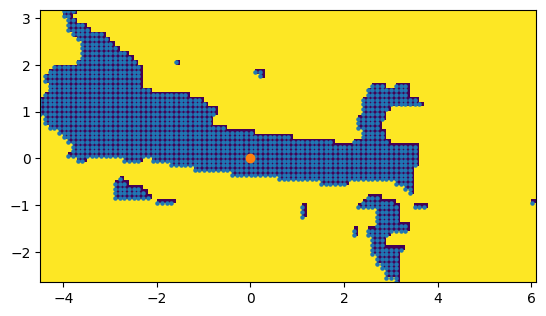

In [35]:
plt.scatter(points[:, 0], points[:, 1], s = 5)
plt.imshow(grid_planner.occ_map.grid[::-1], extent=(minx, maxx, miny, maxy))
plt.scatter(0, 0)

In [32]:
points = np.load('map.npy')
[2.09348162, 0.24926057] in points

False

In [34]:
for point in points:
    print(point)

[-4.4921875  0.9515625]
[-4.4921875  1.0515625]
[-4.4921875  1.1515625]
[-4.4921875  1.2515625]
[-4.3921875  0.7515625]
[-4.3921875  0.8515625]
[-4.3921875  0.9515625]
[-4.3921875  1.0515625]
[-4.3921875  1.1515625]
[-4.3921875  1.2515625]
[-4.3921875  1.3515625]
[-4.3921875  1.6515625]
[-4.3921875  1.7515625]
[-4.2921875  0.6515625]
[-4.2921875  0.7515625]
[-4.2921875  0.8515625]
[-4.2921875  0.9515625]
[-4.2921875  1.0515625]
[-4.2921875  1.1515625]
[-4.2921875  1.2515625]
[-4.2921875  1.3515625]
[-4.2921875  1.4515625]
[-4.2921875  1.5515625]
[-4.2921875  1.6515625]
[-4.2921875  1.7515625]
[-4.2921875  1.8515625]
[-4.1921875  0.6515625]
[-4.1921875  0.7515625]
[-4.1921875  0.8515625]
[-4.1921875  0.9515625]
[-4.1921875  1.0515625]
[-4.1921875  1.1515625]
[-4.1921875  1.2515625]
[-4.1921875  1.3515625]
[-4.1921875  1.4515625]
[-4.1921875  1.5515625]
[-4.1921875  1.6515625]
[-4.1921875  1.7515625]
[-4.1921875  1.8515625]
[-4.1921875  1.9515625]
[-4.0921875  0.5515625]
[-4.0921875  0.6